# Analyzing a Time Series of the Thames River in Python

## By: Vatsal Vinay Parikh

Time series data is everywhere, from watching your stock portfolio to monitoring climate change, and even live-tracking as local cases of a virus become a global pandemic. In this project, you’ll work with a time series that tracks the tide levels of the Thames River. You’ll first load the data and inspect it data visually, and then perform calculations on the dataset to generate some summary statistics. Next, you’ll decompose the time series into its component attributes. You’ll end with a taster of autocorrelation: a first step in time series forecasting.

The original dataset is available from the British Oceanographic Data Center [here](https://www.bodc.ac.uk/data/published_data_library/catalogue/10.5285/b66afb2c-cd53-7de9-e053-6c86abc0d251) and you can read all about this fascinating archival story in [this article](https://www.nature.com/articles/s41597-022-01223-7) from the Nature journal.

Here's a map of the locations of the tidal gauges along the River Thames in London.

![](locations.png)

In [2]:
# Package imports
import pandas as pd                # for data manipulation
import seaborn as sns              # for data visualization
import matplotlib.pyplot as plt    # for data visualization

## Read one file to explore the data format and prepare the data for analysis.

The dataset consists of 13 .txt files, containing comma separated data. We'll begin by analyzing one of them and preparing it for analysis. We can then create a helper function in case you are interested in analyzing other data later.

The dataset comes with a file called `Data_description.pdf`. 

| Variable Name | Description | Format |
| ------------- | ----------- | ------ |
| Date and time | Date and time of measurement to GMT. Note the tide gauge is accurate to one minute. | dd/mm/yyyy hh:mm:ss |
| Water level | High or low water level measured by tide gauge. Tide gauges are accurate to 1 centimetre. | metres (Admiralty Chart Datum (CD), Ordnance Datum Newlyn (ODN or Trinity High Water (THW)) | 
| Flag | High water flag = 1, low water flag = 0 | Categorical (0 or 1) |

Let's begin by loading the London Bridge data. When loading time series data, always look out for the time zone the data is provided in. Sometimes, your data might be provided in UTC, and will need to be converted to local time if you want to do local analysis. Fortunately, the description above tells us the data is in GMT, which is the same as coordinated universal time (UTC).

### Instructions

- Use pandas to read the London Bridge dataset from the CSV file named `Data/10-11_London_Bridge.txt` and assign it to the variable `lb`.
- Display `lb`.

In [3]:
lb = pd.read_csv('Data/10-11_London_Bridge.txt') # Comma-separated .txt file
lb

,Date and time,water level (m ODN),flag,HW=1 or LW=0
0,01/05/1911 15:40:00,3.7130,1,NaN
1,02/05/1911 11:25:00,-2.9415,0,NaN
2,02/05/1911 16:05:00,3.3828,1,NaN
3,03/05/1911 11:50:00,-2.6367,0,NaN
4,03/05/1911 16:55:00,2.9256,1,NaN
...,...,...,...,...
115498,30/12/1995 20:44:00,3.2900,1,NaN
115499,31/12/1995 02:32:00,-1.6000,0,NaN
115500,31/12/1995 08:59:00,3.2000,1,NaN
115501,31/12/1995 15:03:00,-1.8000,0,NaN


Since one of the column headings in the csv file had a comma (`"flag, HW=1 or LW=0"`), `pd.read_csv` has created an extra, empty column. We'll need to drop this extra column and rename our column headings. Shorter and more memorable column names will facilitate our analysis later on.

### Instructions
- Call `lb.info()` or `lb.describe()` to confirm that the last column is empty and contains no data.
- Create a new DataFrame `df` which takes only the first three columns and rename them as `datetime`, `water_level`, and `is_high_tide`, respectively. 

In [4]:
lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115503 entries, 0 to 115502
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date and time         115503 non-null  object 
 1    water level (m ODN)  115503 non-null  object 
 2    flag                 115503 non-null  int64  
 3    HW=1 or LW=0         0 non-null       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.5+ MB


In [5]:
# Take only the first three columns
df = lb[lb.columns[0:3]]

# Rename columns
df.columns = ['datetime', 'water_level', 'is_high_tide']

Calling `lb.info()` above showed us both the `datetime` and `water_level` columns are of type `object`. We'll convert these to `datetime` and `water_level`, respectively. We'll also add two columns, `month` and `year`, which we'll need to access later on.

### Instructions
- Use `pd.to_datetime()` to convert the `datetime` column to the `datetime` format. Since the dataset is large, this step can take a few seconds.
- Use `.astype(float)` to convert the `water_level` column to the `float` format.

In [6]:

# Convert to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert to float
df['water_level'] = df.water_level.astype(float)

# Create extra month and year columns for easy access
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

df

,datetime,water_level,is_high_tide,month,year
0,1911-01-05 15:40:00,3.7130,1,1,1911
1,1911-02-05 11:25:00,-2.9415,0,2,1911
2,1911-02-05 16:05:00,3.3828,1,2,1911
3,1911-03-05 11:50:00,-2.6367,0,3,1911
4,1911-03-05 16:55:00,2.9256,1,3,1911
...,...,...,...,...,...
115498,1995-12-30 20:44:00,3.2900,1,12,1995
115499,1995-12-31 02:32:00,-1.6000,0,12,1995
115500,1995-12-31 08:59:00,3.2000,1,12,1995
115501,1995-12-31 15:03:00,-1.8000,0,12,1995


Before moving on to conduct analysis, let's define a helper function for data cleaning so we don't have to do this each time. The function takes a `DataFrame` (which we'll read from our `.txt` files), renames the columns, formats the `datetime` column, and converts `water_level` to a `float` data type.

In [7]:

def clean_data(data):
    # Take only the first three columns
    data = data[data.columns[0:3]]

    # Rename columns
    data.columns = ['datetime', 'water_level', 'is_high_tide']

    # Convert `datetime` to `datetime` format
    data['datetime'] = pd.to_datetime(data['datetime'])
    
    # Conver `water_level` to float format
    data['water_level'] = data['water_level'].astype(float)

    # Create extra month and year columns for easy access
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year
    
    return data

## Analyze the London Bridge data to get a sense of the water level.

Let's begin analyzing the data with a `displot()` of `water_level`. This plot shows that the data is bimodal, meaning it has two separate peaks. When we plot the data with `is_high_tide=0 `and `is_high_tide=1`, separately we get two approximately normal distributions, with separate means and variances. Moving forward, we'll analyze low tide and high tide data separately.

### Instructions
- Create a `hist` of `df` where `is_high_tide=0`.
- Create a `hist` of `df` where `is_high_tide=1`.
- Call `plt.show()`.

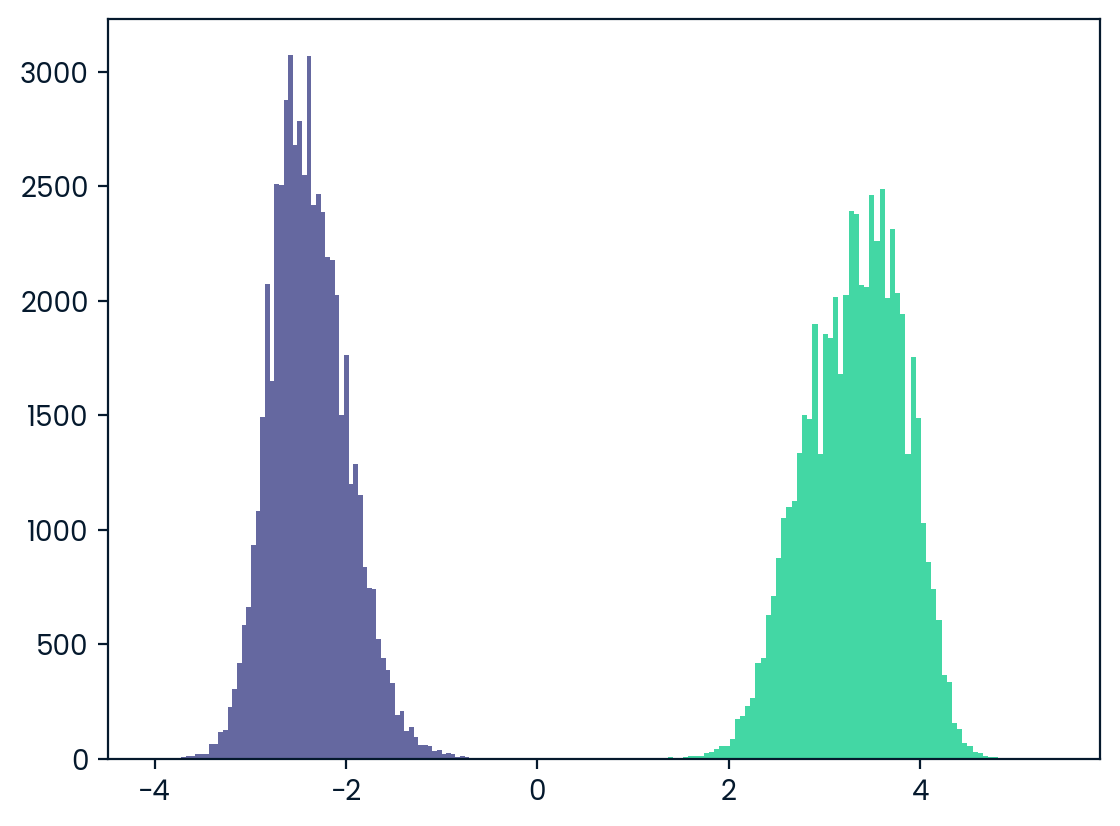

In [8]:
plt.hist(df.query('is_high_tide==0')['water_level'],bins=100)
plt.hist(df.query('is_high_tide==1')['water_level'],bins=100)
plt.show()

Boxplots will give us a sense of the min, max, range, and outliers of the data. We'll create these separately for high tide and low tide. By default, the whiskers of the boxplot will show us 1.5 * the interquartile range.

### Instructions
- Create a boxplot of `df` where `is_high_tide==0`.
- Create a boxplot of `df` where `is_high_tide==1`.

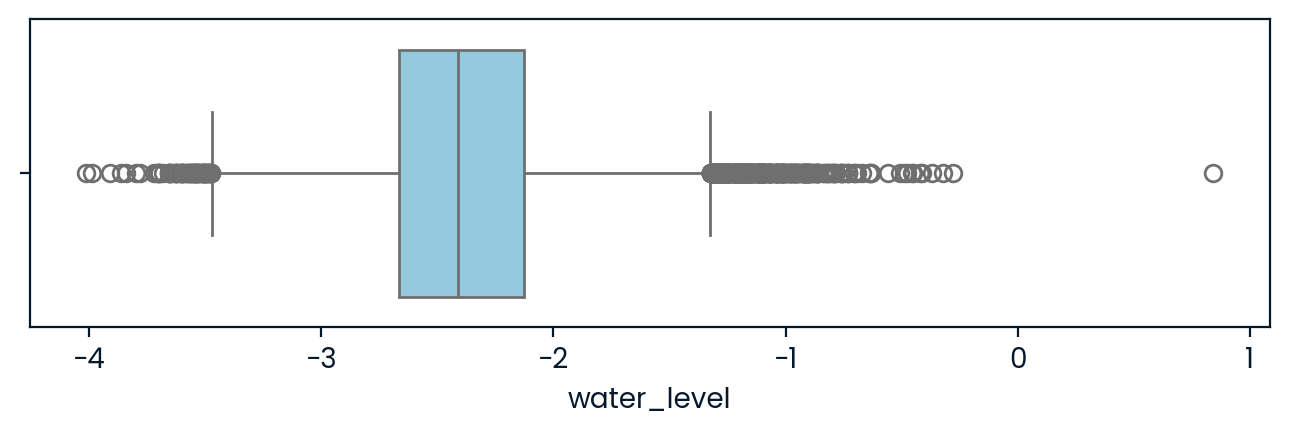

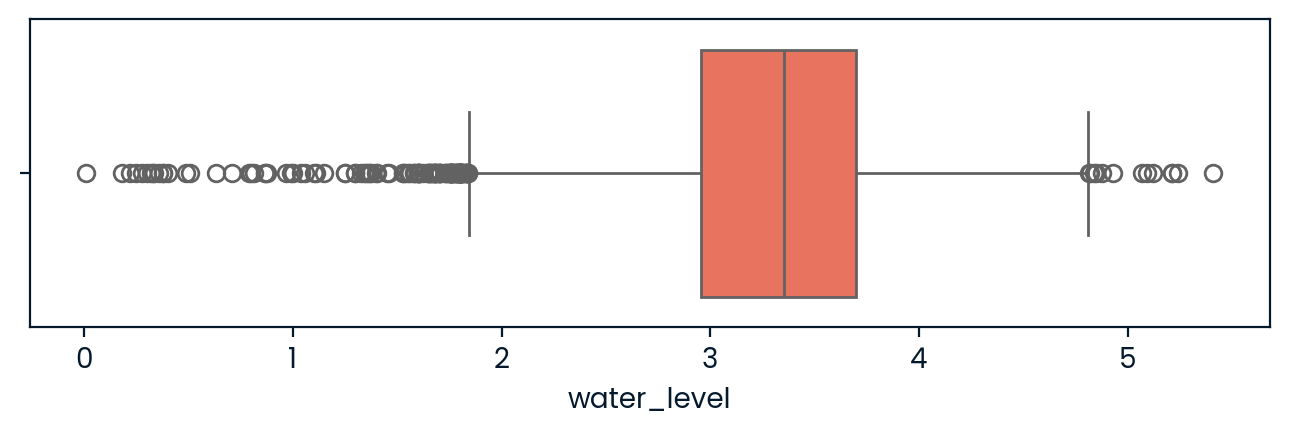

In [9]:
plt.figure(figsize=(8,2))
sns.boxplot(data=df.query('is_high_tide==0'),x='water_level',color='SkyBlue')
plt.show()
plt.figure(figsize=(8,2))
sns.boxplot(data=df.query('is_high_tide==1'),x='water_level',color='Tomato')
plt.show()

We can use the information gathered from our boxplots and summary statistics to count the number of days London Bridge has had high tide over the last 84 years.

### Instructions
- Use `.describe()` to summarize `water_level` where `is_high_tide==1`.
- Count the number of days of data we have per year in `df`.
- Count the number of days of data where water level was above the 75th percentile in `df`.

In [10]:
df.query('(is_high_tide==1)').describe()

,water_level,is_high_tide,month,year
count,57909.000000,57917.0,57917.000000,57917.000000
mean,3.318373,1.0,6.534126,1953.701400
std,0.509422,0.0,3.441167,24.334694
min,0.010000,1.0,1.000000,1911.000000
25%,2.956400,1.0,4.000000,1933.000000
50%,3.352600,1.0,7.000000,1954.000000
75%,3.700000,1.0,10.000000,1975.000000
max,5.409900,1.0,12.000000,1995.000000


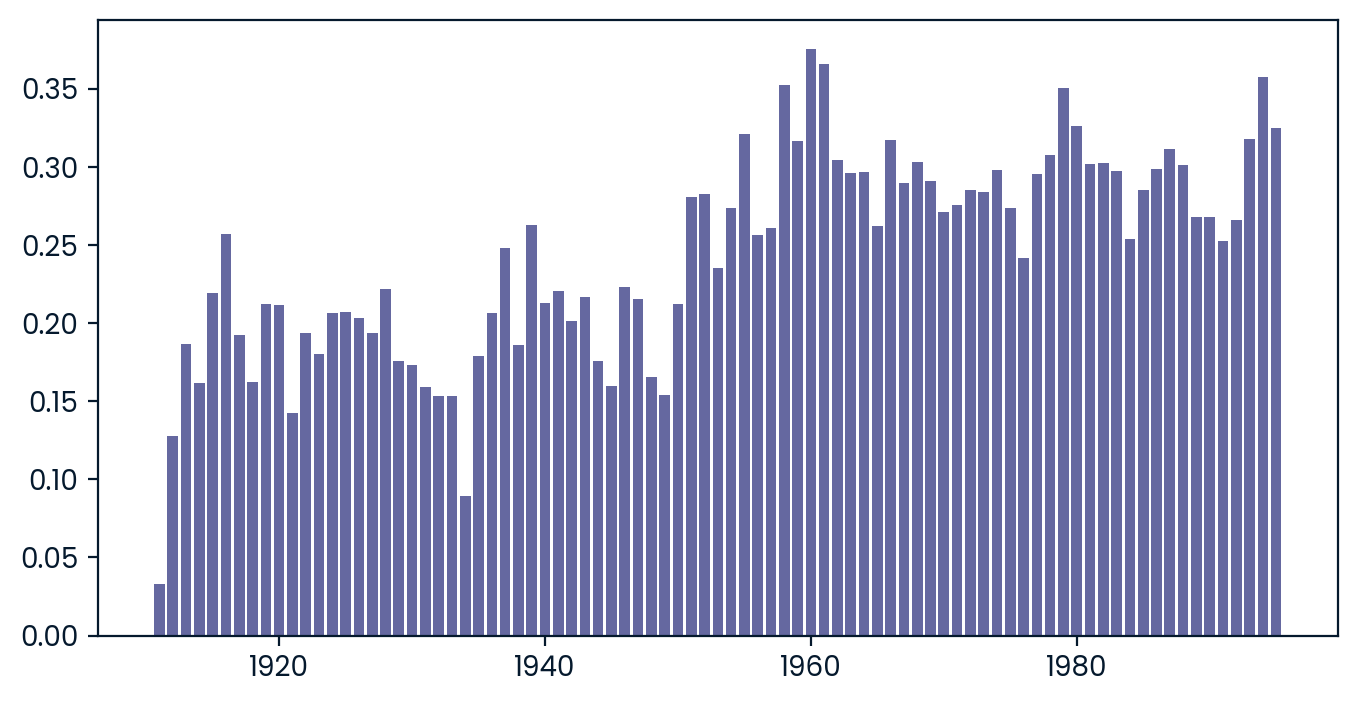

In [11]:
plt.figure(figsize=(8,4))
all_days = df.query('is_high_tide==1').groupby('year').count()['water_level']
high_days = df.query('(water_level>3.7) & (is_high_tide==1)').groupby('year').count()['water_level']
ratio = (high_days/all_days).reset_index()
plt.bar(ratio.year,ratio.water_level)
plt.show()

### Instructions
- Use `.describe()` to summarize `water_level` where `is_high_tide==0`.
- Count the number of days of low tide we have per year in `df`.
- Count the number of days of low tide data where water level was below the 25th percentile in `df`.

In [12]:
df.query('(is_high_tide==0)').describe()

,water_level,is_high_tide,month,year
count,57580.000000,57586.0,57586.000000,57586.000000
mean,-2.383737,0.0,6.532491,1953.671708
std,0.399748,0.0,3.444258,24.366551
min,-4.013000,0.0,1.000000,1911.000000
25%,-2.666900,0.0,4.000000,1933.000000
50%,-2.412900,0.0,7.000000,1954.000000
75%,-2.128700,0.0,10.000000,1975.000000
max,0.842900,0.0,12.000000,1995.000000


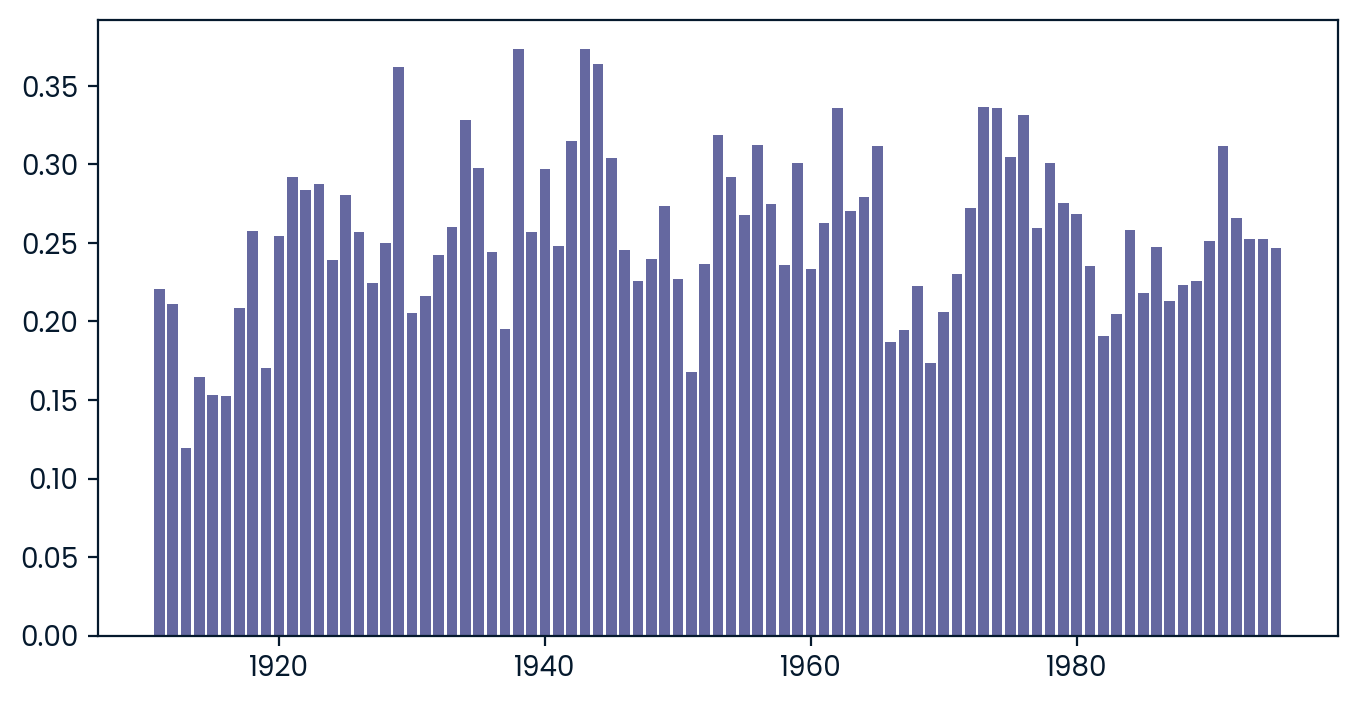

In [13]:
plt.figure(figsize=(8,4))
all_days = df.query('is_high_tide==0').groupby('year').count()['water_level']
high_days = df.query('(water_level<-2.66) & (is_high_tide==0)').groupby('year').count()['water_level']
ratio = (high_days/all_days).reset_index()
plt.bar(ratio.year,ratio.water_level)
plt.show()

## Assess monthly trends in water level for 1927, 1928 and 1929.

### Instructions
- Create an empty DataFrame.
- Loop through an array of years 1927, 1928 and 1929.
- For each year, group the data by `is_high_tide` and resample by `1M`, calculating the `median`.
- Plot the high tide data for these months, with a horizontal line indicating the median of high tide data in these months.
- Plot the low tide data for these months, with a horizontal line indicating the median of low tide data in these months.

In [14]:
water_level = pd.DataFrame()

for year in [1927, 1928, 1929]:
    level_per_year = df.query(f'year=={year}').set_index('datetime')
    level_per_year = level_per_year.groupby('is_high_tide').resample('1M').median()['water_level'].reset_index()
    level_per_year['month'] = level_per_year.datetime.dt.month
    level_per_year['year'] = level_per_year.datetime.dt.year    
    water_level = pd.concat([water_level, level_per_year]).reset_index(drop=True)


In [15]:
water_level[water_level['is_high_tide']==0].describe()

,is_high_tide,water_level,month,year
count,36.0,36.000000,36.00000,36.000000
mean,0.0,-2.447082,6.50000,1928.000000
std,0.0,0.095536,3.50102,0.828079
min,0.0,-2.611300,1.00000,1927.000000
25%,0.0,-2.509700,3.75000,1927.000000
50%,0.0,-2.462075,6.50000,1928.000000
75%,0.0,-2.382700,9.25000,1929.000000
max,0.0,-2.141400,12.00000,1929.000000


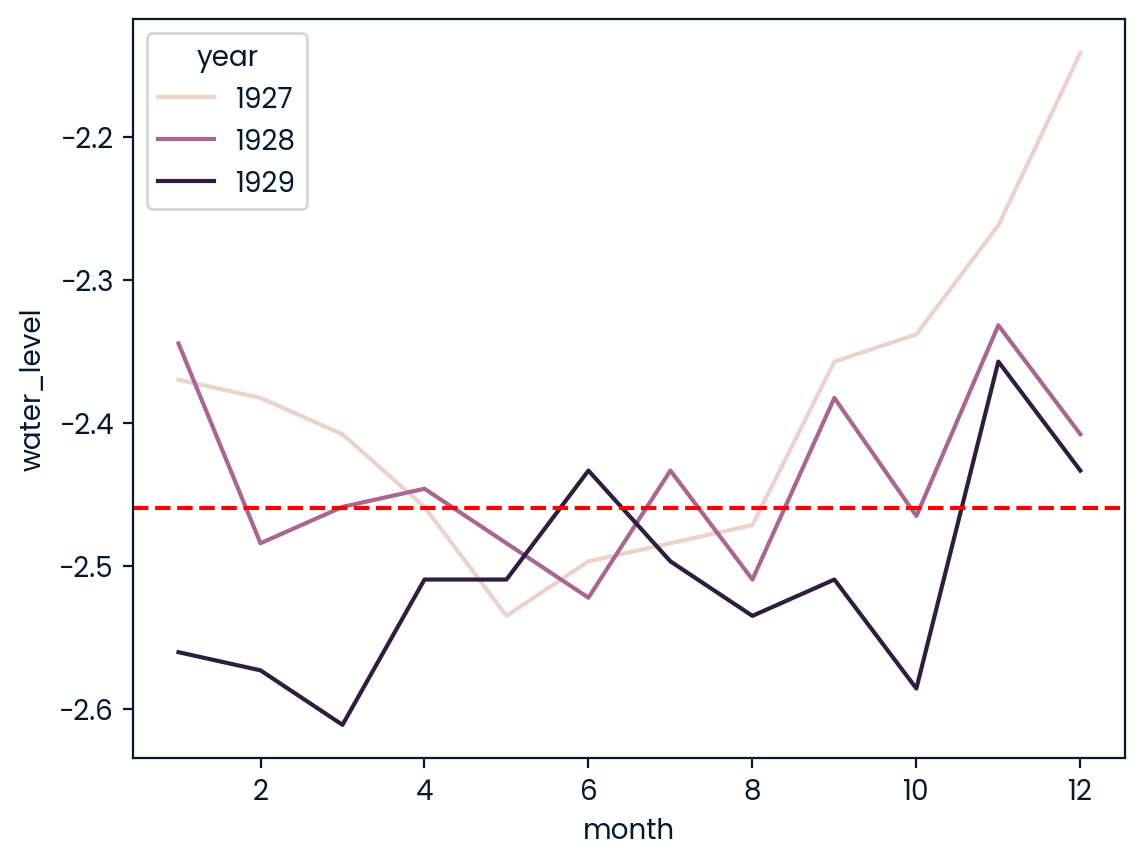

In [16]:
sns.lineplot(data=water_level[water_level['is_high_tide']==0],y='water_level',x='month',hue='year')
plt.axhline(-2.46,0,12,linestyle='--',color='red')
plt.show()

How might you interpret this graph?

The graph shows the water levels during low tide for the years 1927, 1928, and 1929, with each year represented by a different line. The x-axis represents the months of the year, while the y-axis represents the water level. 

Key points to interpret:
1. **Seasonal Variation**: Observe if there are any seasonal patterns in the water levels. For instance, do certain months consistently show higher or lower water levels across the years?
2. **Yearly Comparison**: Compare the water levels between the years. Are there significant differences in the water levels for the same month across different years?
3. **Median Line**: The red dashed horizontal line represents the median water level for low tides across these months. This helps in understanding how the monthly water levels compare to the overall median.
4. **Anomalies**: Look for any anomalies or outliers where the water level significantly deviates from the median line.

Overall, this graph can help in understanding the trends and variations in low tide water levels over the specified years and months.

In [17]:
water_level[water_level['is_high_tide']==1].describe()

,is_high_tide,water_level,month,year
count,36.0,36.000000,36.00000,36.000000
mean,1.0,3.266560,6.50000,1928.000000
std,0.0,0.104571,3.50102,0.828079
min,1.0,3.039900,1.00000,1927.000000
25%,1.0,3.209763,3.75000,1927.000000
50%,1.0,3.249450,6.50000,1928.000000
75%,1.0,3.324063,9.25000,1929.000000
max,1.0,3.459000,12.00000,1929.000000


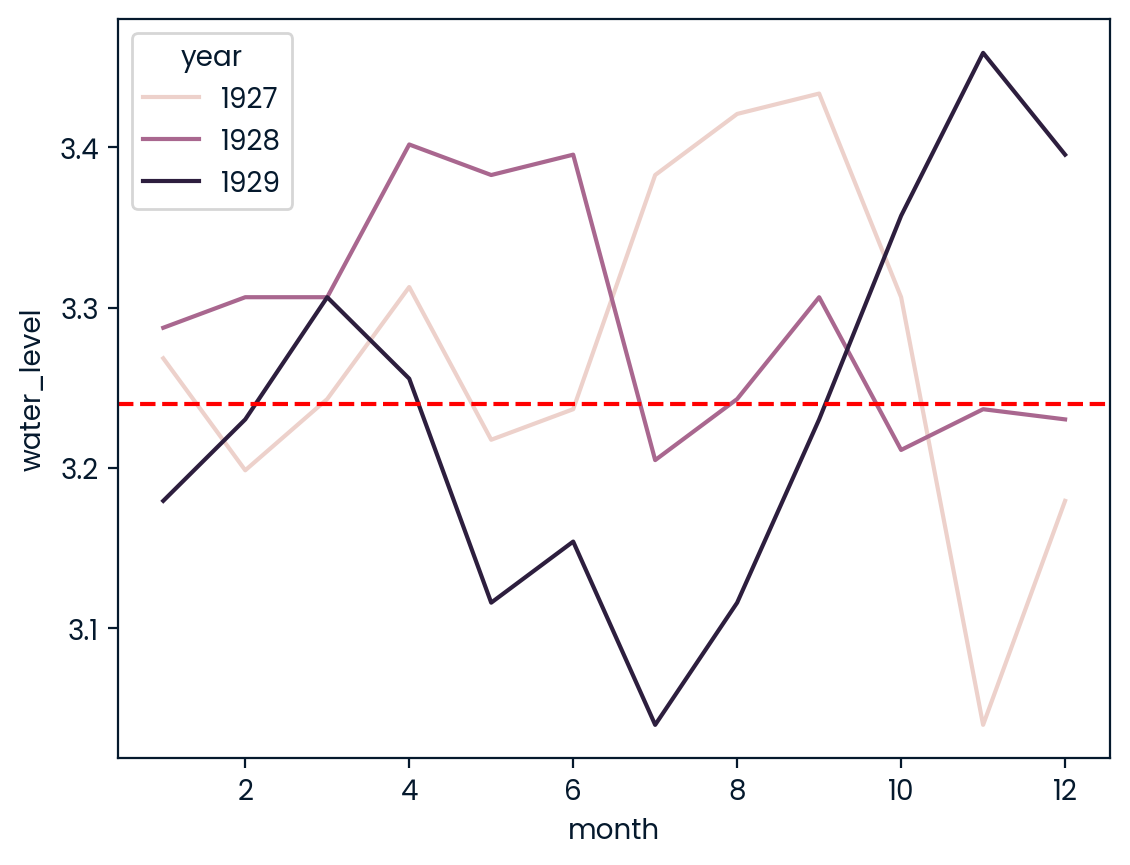

In [18]:
sns.lineplot(data=water_level[water_level['is_high_tide']==1],y='water_level',x='month',hue='year')
plt.axhline(3.24,0,12,linestyle='--',color='red')
plt.show()

How might you interpret this graph?

The graph illustrates the water levels during high tide for the years 1927, 1928, and 1929, with each year represented by a different line. The x-axis represents the months of the year, while the y-axis represents the water level. 

Key points to interpret:
1. **Seasonal Variation**: The graph shows a clear seasonal pattern in the water levels, with certain months consistently showing higher or lower water levels across the years.
2. **Yearly Comparison**: There are noticeable differences in the water levels for the same month across different years. For example, the water levels in 1927 are generally higher compared to 1928 and 1929.
3. **Median Line**: The red dashed horizontal line represents the median water level for high tides across these months. This helps in understanding how the monthly water levels compare to the overall median.
4. **Anomalies**: There are some anomalies where the water level significantly deviates from the median line, such as in certain months of 1928 where the water levels are much lower.

Overall, this graph provides insights into the trends and variations in high tide water levels over the specified years and months.

## Beginning a forecasting model for London Bridge: a taste of autocorrelation.

In [19]:
df28 = df.query('(year==1928) & (month<=6)').reset_index()

When looking at the **high tide levels** for a sample of the data, it appears to have some monthly peaks and troughs.

We can compute a metric called autocorrelation to quantify this repeating pattern. We find that autocorrelation is highest at 15 days (waxing and waning of the moon).

### Instructions
- Plot the high tide data for `df28`.
- Compute the autocorrelation of `df28` at yearly, monthly, biweekly and daily frequencies.

In [51]:
# This is a chart, switch to the DataCamp editor to view and configure it.

,index,datetime,water_level,is_high_tide,month,year
2,21701,1928-01-01 07:14:00,3.1034,1,1,1928
4,21703,1928-01-01 20:02:00,3.0780,1,1,1928
6,21705,1928-02-01 08:25:00,2.1637,1,2,1928
8,21707,1928-02-01 21:44:00,3.3828,1,2,1928
10,21709,1928-03-01 08:09:00,3.1542,1,3,1928
...,...,...,...,...,...,...
690,22998,1928-04-12 19:58:00,2.8367,1,4,1928
692,23000,1928-05-12 08:00:00,2.3796,1,5,1928
694,23002,1928-05-12 21:00:00,3.1034,1,5,1928
696,23004,1928-06-12 08:44:00,2.4938,1,6,1928


<AxesSubplot: xlabel='datetime', ylabel='water_level'>

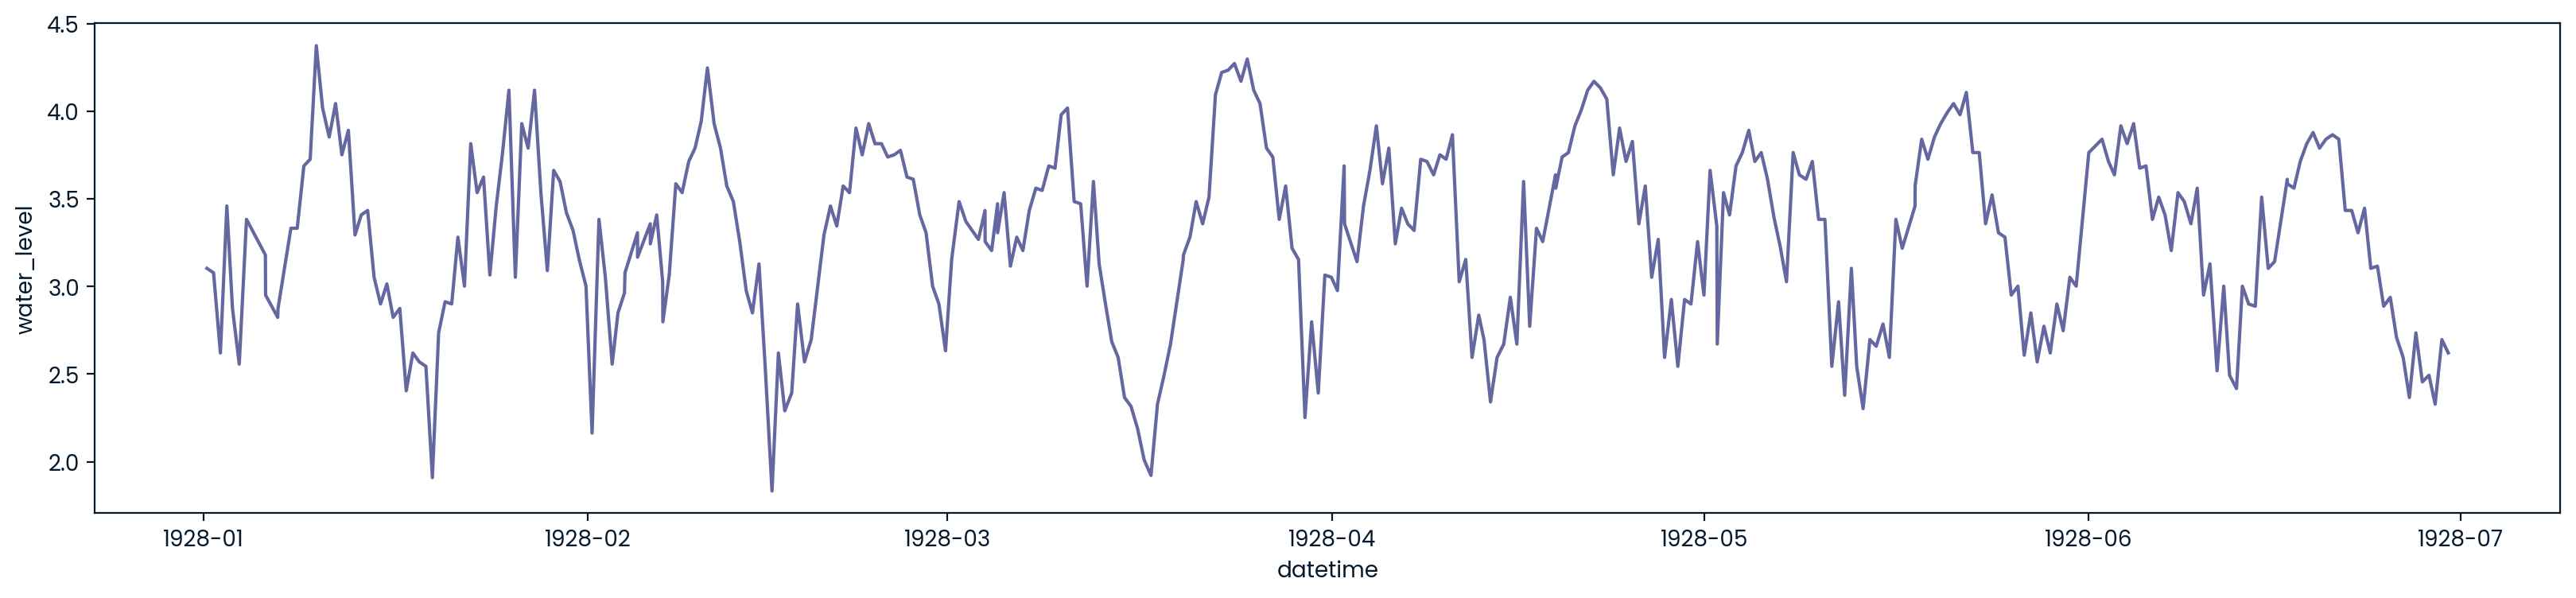

In [20]:
fig, ax = plt.subplots(figsize=(20,4))
sns.lineplot(data=df28.query('is_high_tide==1'),x='datetime',y='water_level', ax=ax)

In [21]:
def autocorr(data,level='1D',flag=0):
    high_low = {0:'high',1:'low'}
    level_dict = {'1D':'daily','15D':'biweekly','1M':'monthly','1Y':'annual'}    
    data = data[data['is_high_tide']==flag].set_index('datetime').resample(level).mean()['water_level']
    diff = data.diff()
    autocorrelation = diff.autocorr()
    print(f"The autocorrelation of {level_dict[level]} {high_low[flag]} values is %4.2f" %(autocorrelation))


In [22]:
autocorr(df,level='1Y',flag=1)
autocorr(df,level='1Y',flag=0)
autocorr(df,level='1M',flag=1)
autocorr(df,level='1M',flag=0)
autocorr(df,level='15D',flag=1)
autocorr(df,level='15D',flag=0)
autocorr(df,level='1D',flag=1)
autocorr(df,level='1D',flag=0)

The autocorrelation of annual low values is -0.19
The autocorrelation of annual high values is -0.23
The autocorrelation of monthly low values is -0.27
The autocorrelation of monthly high values is -0.23
The autocorrelation of biweekly low values is -0.78
The autocorrelation of biweekly high values is -0.72
The autocorrelation of daily low values is 0.01
The autocorrelation of daily high values is -0.13
